# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way Doppler data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging Doppler data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas_data = []

sim_altair_rv = []
sim_millstone_rv = []

for e in ssn_epochs:
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrAltair.rv_with_rangelag(rv, e)
    sim_altair_rv.append(sim_rv)
    sim_millstone_rv.append(ssrMillstone.rv_with_rangelag(rv, e))

    sim_r, sim_rr = ssrAltair.range_and_rate(sim_rv, e)
    sim_meas_data.append([sim_r])

print(sim_meas_data)

[[<Quantity 35482.10823583 km>], [<Quantity 34992.67025567 km>], [<Quantity 34503.06081226 km>], [<Quantity 34013.28827363 km>], [<Quantity 33523.36197989 km>], [<Quantity 33033.29233821 km>], [<Quantity 32543.09092759 km>], [<Quantity 32052.77061475 km>], [<Quantity 31562.34568238 km>], [<Quantity 31071.83197126 km>], [<Quantity 30581.2470378 km>], [<Quantity 30090.61032905 km>], [<Quantity 29599.94337722 km>], [<Quantity 29109.27001614 km>], [<Quantity 28618.61662249 km>], [<Quantity 28128.01238489 km>], [<Quantity 27637.4896045 km>], [<Quantity 27147.08403129 km>], [<Quantity 26656.83524051 km>], [<Quantity 26166.78705504 km>], [<Quantity 25676.98801954 km>], [<Quantity 25187.49193376 km>], [<Quantity 24698.35845298 km>], [<Quantity 24209.65376518 km>], [<Quantity 23721.45135568 km>], [<Quantity 23233.83287189 km>], [<Quantity 22746.88910255 km>], [<Quantity 22260.72108818 km>], [<Quantity 21775.44138216 km>], [<Quantity 21291.17548454 km>], [<Quantity 20808.06347458 km>], [<Quantit

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, [ssrAltair], debug=True)

Range constraints:
a: -8409373.858285213 -8579260.198856631
ecc: 1.7952252079089492 1.831492383826302
inc: 1.8656334554096003 1.90332302016535


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_range_data(ssn_epochs, sim_meas_data)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.02730517, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.813358796137837, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782380682843, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8

In [8]:
print(fitter.result.residual)

[-0.01668691 -0.02449442 -0.03046924 -0.03481355 -0.0377258  -0.03939991
 -0.0400245  -0.03978237 -0.03884931 -0.0373933  -0.03557355 -0.03353927
 -0.03142899 -0.02936862 -0.02747081 -0.02583343 -0.02453806 -0.0236489
 -0.02321117 -0.02324974 -0.02376823 -0.02474753 -0.02614524 -0.02789505
 -0.02990684 -0.03206751 -0.03424248 -0.03627923 -0.03801169 -0.0392675
 -0.03987844 -0.0396946  -0.03860389 -0.03655846 -0.03361026 -0.02995779
 -0.02600825 -0.02245892 -0.02040379 -0.02147231 -0.02800986 -0.04331122]


In [9]:
fitted_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(fitted_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32465.03389201371 km 14334.661388376962 km
Start and end radial speeds: -7.678671178358486 km / s -6.934986202233803 km / s
Closest: 14334.661388376962 km speed 9.426692288519341 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302408824039747 deg


In [10]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, e in enumerate(ssn_epochs):
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitted_ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitted_ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitted_ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

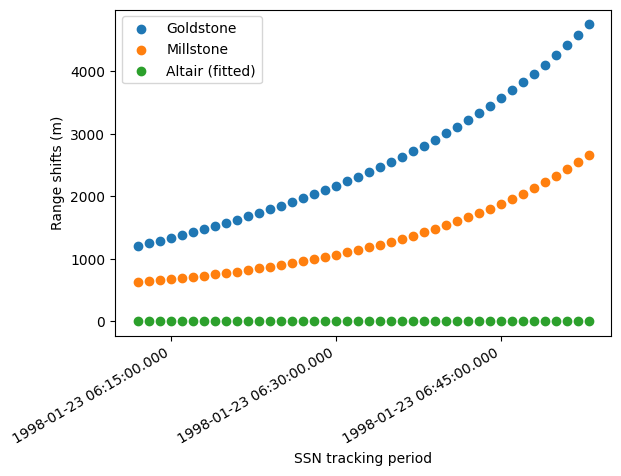

In [11]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs, millstone_shifts, label="Millstone")
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.plot(ssn_epochs, altair_shifts, 'bo-', label="Altair (fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [12]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for e in ssn_epochs:
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitted_ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitted_ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitted_ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

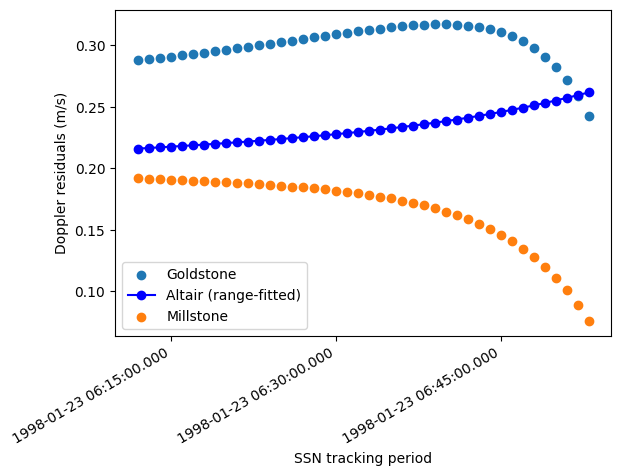

In [13]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.plot(ssn_epochs, altair_doppler, 'bo-', label="Altair (range-fitted)")
    plt.scatter(ssn_epochs, millstone_doppler, label="Millstone")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()